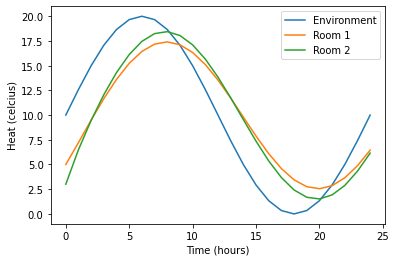

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

def two_body_house_solution(k1,k2,k3,k4,Te_const,Te_sin_coef,Tg,x0,y0,f0,f1):

  # first we create our transition matrix K
  kP1 = -k1 - k2 - k3
  kP2 = k2
  kP3 = k2 
  kP4 = -k2 - k4
  K = [ [kP1, kP2], [kP3, kP4] ]

  # to solve for our homogenous solution, we need the eigenvalues and eigen vectors
  EigVals, EigVectors = np.linalg.eig(K)
  EigVectors[:,0] = EigVectors[:,0] / np.abs(EigVectors[0,0]) * -1
  EigVectors[:, 1] = EigVectors[:, 1] / np.abs(EigVectors[1, 1]) * -1
  # with the eigen vectors and eigen values we have a solution of 
  firstSolution = lambda t,c1,c2: c1*np.exp(EigVals[0]*t)*EigVectors[1,:] + c2*np.exp(-.5*t)*EigVectors[0,:]

  # This system of equations was derived by hand
  System_of_equations = [ [ np.pi/12, 0, -kP1, -kP2, 0, 0 ], 
    [ -kP1, -kP2, -np.pi/12, 0, 0, 0 ], 
    [ 0, 0, 0, 0, -kP1, -kP2 ],
    [ 0, np.pi/12, -kP3, -kP4, 0, 0 ],
    [ -kP2, -kP4, 0, -np.pi/12, 0, 0 ],
    [ 0, 0, 0, 0, -kP3, -kP4 ]
    ]
  targets = [ 0, k3*Te_sin_coef, k3*Te_sin_coef+Tg*k1, 0, k4*Te_const, k4*Te_const ]
  # we then use a little linear algebra to get our unkown coefficients
  A1,A2,B1,B2,D1,D2 = np.linalg.solve(System_of_equations, targets)

  # with our coefficients sovled for, we hare a solution to our first non-homogenous solution
  secondSolution = lambda t: np.array([ D1 + A1*np.sin(t*np.pi/12) + B1*np.cos(t*np.pi/12), D2 + A2*np.sin(t*np.pi/12) + B2*np.cos(t*np.pi/12) ])

  # since we are simply treating our heating term as a constant solving the 
  # second non-homogenous solution is simply finding two constants G, H that make X
  G, H = np.linalg.solve(np.array(K), -np.array([f0,f1]))
  thirdSolution = lambda t: np.array([G, H])

  # our final solution is made simply by combining all previous solutions
  collectiveSolution = lambda t, c1, c2: firstSolution(t,c1,c2) + secondSolution(t) + thirdSolution(t)
  initialPoint = collectiveSolution(0,0,0)
  # quick calculations for our final coefficients based off our initial values
  C = [ [-1,1], [1,1] ]
  b = [ x0 - initialPoint[0], y0 - initialPoint[1] ]
  C1,C2 = np.linalg.solve(C, b)
  final_solution = lambda t: np.array([collectiveSolution(sub_t, C1, C2) for sub_t in t])

  return final_solution

# thermal conducitivity floor
k1 = 1/10
# thermal conductivity ceiling
k2 = 1/5
# thermal conductivity walls on first floor
k3 = 2/5
# thermal conductivity walls on second floor
k4 = 1/2
# tempurature of ground
Tg = 10
# coefficients for environment tempurature
Te_const = 10
Te_sin_coef = 10
# heat source first floor
f0 = 0
# heat source second floor
f1 = 0

# inital tempurature first floor
x0 = 5
# initial tempurature second floor
y0 = 3

# solution function
T = two_body_house_solution(k1,k2,k3,k4,Te_const,Te_sin_coef,Tg,x0,y0,f0,f1)

# environemnt tempurature function
Tg = lambda t: Te_const + Te_sin_coef*np.sin(np.pi/12*t)

# plotting
x_range = np.arange(0,25)
plt.xlabel("Time (hours)")
plt.ylabel("Heat (celcius)")
plt.plot(x_range, Tg(x_range), label="Environment")
T1 = T(x_range).T[0]
T2 = T(x_range).T[1]
plt.plot(x_range, T1, label="Room 1")
plt.plot(x_range, T2, label="Room 2")
plt.legend()

(9, 9)


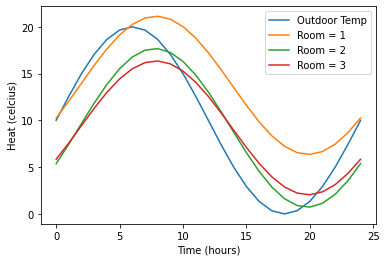

In [ ]:
import numpy as np

def arbitrary_number_of_rooms_solution(thernal_floor, thermal_internal_walls, thermal_external_walls,Te_const,Te_sin_coef,Tg,T0,f):
  num_rooms = len(thermal_internal_walls)

  # first we create our transition matrix K
  K = []
  # create row for each room
  for i in range(num_rooms):
    # create entry for each connection from that room
    row = []
    for j in range(num_rooms):
      if i == j:
        row.append(-thernal_floor[i] - thermal_external_walls[i] - sum(thermal_internal_walls[i]))
      else:
        row.append(thermal_internal_walls[i][j])
    K.append(row)
  K = np.array(K)

  # find inhomogenous solution with eigen values and eigen vectors
  EigVals, EigVectors = np.linalg.eig(K)
  temp = EigVectors[:,0] / np.abs(EigVectors[0,0])
  EigVectors = np.array([ EigVectors[:,i] / np.abs(EigVectors[0,i]) for i in range(num_rooms) ])
  firstSolution = lambda t,c: np.sum([ c[i]*np.exp(EigVals[i])*EigVectors[i] for i in range(num_rooms) ])

  # for second equation, we need a list of coefficients to solve for

  # A is a 3*num_rooms by 3*num_rooms matrix
  A_matrix = []
  # b is a 3*num_rooms matrix
  b_matrix = []

  for i in range(num_rooms):
    # sin, cos, and con will will have a coefficient for each room. 
    # We wish to find all relivent constraints to each of these coefficients for each room
    # we will assign a seperate row for each coefficient for each room
    Si = np.zeros(num_rooms*3)
    Co = np.zeros(num_rooms*3)
    Con = np.zeros(num_rooms*3)
    
    # constants from left hand side of the equation
    Si[i+num_rooms] += -np.pi/12
    Co[i] += np.pi/12

    for j in range(num_rooms):
      # right hand side of equation needs to be subtracted to left
      Si[j] -= K[i][j]
      Co[j+num_rooms] -= K[i][j]
      Con[j+num_rooms*2] -= K[i][j]

    # constants we wish to solve for (from non-homogenous part of equation)
    a = thermal_external_walls[i] * Te_sin_coef
    b = 0
    d = thernal_floor[i]*Tg + thermal_external_walls[i] * Te_const

    # stack three rows of matrix A and vector b
    A_matrix += [Si,Co,Con]
    b_matrix += [a,b,d]

  # convert to numpy then use linear algebra to solve coefficients
  A_matrix = np.array(A_matrix)
  b_matrix = np.array(b_matrix)
  coeff = np.linalg.solve(A_matrix, b_matrix)
  secondSolution = lambda t: np.array([ coeff[i]*np.sin(np.pi/12*t) + coeff[i+num_rooms]*np.cos(np.pi/12*t) + coeff[i+num_rooms*2] for i in range(num_rooms) ])

  # solve coefficient
  coeff2 = np.linalg.solve(K, -np.array(f))
  thirdSolution = lambda t: coeff2

  # make general solution
  collected_solution = lambda t,c: firstSolution(t,c) + secondSolution(t) + thirdSolution(t)

  # calculate final coefficients from initial conditions
  c0 = np.zeros(num_rooms)
  initial_point = collected_solution(0, c0)
  C = EigVectors.T
  real_C = np.linalg.solve(C, T0 - initial_point)
  final_solution = lambda t: np.array([collected_solution(sub_t, real_C) for sub_t in t])
  return final_solution


# thermal conducitivity floor
k1 = 1/10
# thermal conductivity ceiling
k2 = 1/5
# thermal conductivity walls on first floor
k3 = 2/5
# thermal conductivity walls on second floor
k4 = 1/2

# thernal_floor[i] the diffusion coefficient between the house's foundation and room i
thernal_floor = [k1, 0, 1/10]

# thermal_internal_walls[i] is the diffusion coefficients between room i and every 
# other room from room 0 to n (this includes room i which will have a zero coefficient)
thermal_internal_walls = [[0,k2, k2], [k2,0, 0], [k2, 0, 0]]

# thermal_external_walls[i] is the diffusion coefficient between room i and the outdoor environment
thermal_external_walls = [k3, k4, k3]

# Tg is the tempurature of the ground. To keep things simple, we pretend it's constant
Tg = 10

# we assume that the encironment follows the formula E(t) = Te_const + Te_sin_coef*sin(pi/12 * t)
Te_const = 10
Te_sin_coef = 10

# T0[i] is the initial tempurature in room i
T0 = [10,5, 10]

# f[i] is the amount of energy that is beeing added to room i from AC/Heaters
f = [5, 0, 0]

T = arbitrary_number_of_rooms_solution(thernal_floor, thermal_internal_walls, thermal_external_walls,Te_const,Te_sin_coef,Tg,T0,f)

# plotting
plt.xlabel("Time (hours)")
plt.ylabel("Heat (celcius)")
Tg = lambda t: Te_const + Te_sin_coef*np.sin(np.pi/12*t)
x_range = np.arange(0,25)
plt.plot(x_range, Tg(x_range), label="Outdoor Temp")
num_rooms = len(thermal_internal_walls)
for i in range(num_rooms):
  plt.plot(x_range, T(x_range)[:,i], label=f"Room = {i+1}")

plt.legend()
